In [25]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import visuals as vs
# import xgboost as xgb
from xgboost import XGBClassifier
random_state = 6
np.random.seed(random_state)

In [26]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

coloumns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'value']
df_train.columns = coloumns
df_val.columns = coloumns
df_test.columns = coloumns

frames = [df_train, df_val]
df_train = pd.concat(frames)

In [27]:
mms = StandardScaler()
X_train = mms.fit_transform(df_train.drop('value', axis=1))
Y_train = (df_train['value'].values).astype(int)
X_test = mms.fit_transform(df_test.drop('value', axis=1))
Y_test = (df_test['value'].values).astype(int)

In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
XGBModel = XGBClassifier(random_state = random_state)

param_grid ={
    'max_depth' : [2, 3, 4, 5],
    'learning_rate' : [0.001, 0.01, 0.1, 1], 
    'n_estimators' : [50, 100, 150, 200] 
}

grid_clf = GridSearchCV(estimator = XGBModel, param_grid = param_grid, scoring = 'accuracy', cv = cv)

# we have to find out best optimized parameters
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=6,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5], 'learning_rate': [0.001, 0.01, 0.1, 1], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [5]:
# get the best model
print('\n # Best estimator ---------\n{}'.format(grid_clf.best_estimator_))

# Get the best parameters
print('\n # Best parameters ---------\n{}'.format(grid_clf.best_params_))

# best score
print('\n # Best score ---------\n{}'.format(grid_clf.best_score_))


 # Best estimator ---------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=6,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 # Best parameters ---------
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

 # Best score ---------
0.75


In [6]:
best_preds = grid_clf.predict(X_test)

In [7]:
print(pd.crosstab(
    pd.Series(Y_test, name='Actual'),
    pd.Series(best_preds, name='Predicted'),
    margins=True
))

Predicted    0    1  All
Actual                  
0          244   28  272
1           47   81  128
All        291  109  400


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('The accuracy of the model is {}'.format(accuracy_score(Y_test, best_preds)))
print('# Classification report \n {}'.format(classification_report(Y_test, best_preds)))

The accuracy of the model is 0.8125
# Classification report 
              precision    recall  f1-score   support

          0       0.84      0.90      0.87       272
          1       0.74      0.63      0.68       128

avg / total       0.81      0.81      0.81       400



## Use pos_sclae_weight_parameter

In [16]:
ratio = float(np.sum(Y_train.astype(int) == 0)/ np.sum(Y_train.astype(int)==1))

XGBModel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=random_state,
       reg_alpha=0, reg_lambda=1, scale_pos_weight = ratio, seed=None,
       silent=True, subsample=1)

XGBModel.fit(X_train, Y_train.astype(int))
best_preds = XGBModel.predict(X_test)

print(pd.crosstab(
    pd.Series(Y_test, name='Actual'),
    pd.Series(best_preds, name='Predicted'),
    margins=True
))

print('The accuracy of the model is {}'.format(accuracy_score(Y_test, best_preds)))
print('# Classification report \n {}'.format(classification_report(Y_test, best_preds)))

Predicted    0    1  All
Actual                  
0          213   59  272
1           21  107  128
All        234  166  400
The accuracy of the model is 0.8
# Classification report 
              precision    recall  f1-score   support

          0       0.91      0.78      0.84       272
          1       0.64      0.84      0.73       128

avg / total       0.83      0.80      0.81       400



### Custom weights

In [21]:
new_y_train = np.zeros(len(Y_train))
new_y_train[Y_train==0] = 1
new_y_train[Y_train==1] = 3

new_y_test = np.zeros(len(Y_test))
new_y_test[Y_test==0] = 1
new_y_test[Y_test==1] = 3

print(np.shape(new_y_test))
print(np.shape(X_test))

(400,)
(400, 8)


In [30]:
XGBModel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=random_state,
       reg_alpha=0, reg_lambda=1, scale_pos_weight = 3, seed=None,
       silent=True, subsample=1)

XGBModel.fit(X_train, Y_train.astype(int))
best_preds = XGBModel.predict(X_test)

print(pd.crosstab(
    pd.Series(Y_test, name='Actual'),
    pd.Series(best_preds, name='Predicted'),
    margins=True
))

print('The accuracy of the model is {}'.format(accuracy_score(Y_test, best_preds)))
print('# Classification report \n {}'.format(classification_report(Y_test, best_preds)))

Predicted    0    1  All
Actual                  
0          190   82  272
1            6  122  128
All        196  204  400
The accuracy of the model is 0.78
# Classification report 
              precision    recall  f1-score   support

          0       0.97      0.70      0.81       272
          1       0.60      0.95      0.73       128

avg / total       0.85      0.78      0.79       400



## Important features :

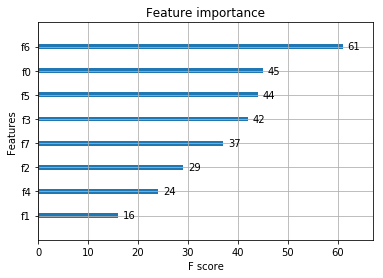

In [36]:
from xgboost import plot_importance, plot_tree
from matplotlib import pyplot

# plot feature importance
plot_importance(XGBModel)
pyplot.show()

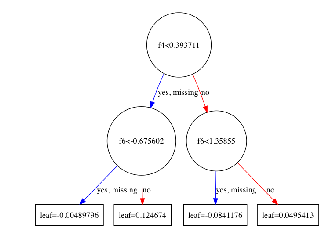

In [38]:
plot_tree(XGBModel)